In [1]:
import sys
sys.path.insert(0, '../')

import matplotlib.pyplot as plt
import numpy as np

from ase import Atoms
from ase.build import bulk
from ase.optimize import BFGS

from scipy.optimize import curve_fit, minimize

from cgf.bnff import MikadoPotential, _energy_total, _get_phi0

In [3]:
def func(x, a, b, c, d):
    return a + b * x + c * x**2 + d * x**3

## Beam Network Force Field (BNFF)

In [5]:
Mikado = MikadoPotential(r0=30.082756/np.sqrt(3), cosT0=-0.5, Kbond=82.003030/2, Kangle=82.312490/2) # Tp-DB-1phenyl

## Bulk Modulus

In [8]:
atoms = bulk('Y', 'hcp', a=30.0827, b=30.0)
atoms.positions[0][2] = 15.0 # vacuum in z-dir
atoms.calc = Mikado

cell_array0 = atoms.cell.array.copy()
cell_array = cell_array0.copy()

A0 = np.cross(cell_array0[0], cell_array0[1])[2]

atoms.get_potential_energy()

1.2858075104528545e-07

In [7]:
pos0 = atoms.get_positions().flatten()
ch0 = atoms.get_initial_charges()

res_tot = minimize(_energy_total, np.concatenate((ch0, pos0)), args=(atoms,), options={'disp': True, 'maxiter': 100, 'gtol': 1e-3})

print('\nE_{def} = %3.2f eV' % (atoms.get_potential_energy()*1e-20 * 6.242e18))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 9
         Gradient evaluations: 1

E_{def} = 0.00 eV


In [9]:
# uniform deformation
strain = 0.01 # strain increment
energies = []

for fac in np.arange(-5,4):
    cell_array[0] = (1.0 + fac*strain) * cell_array0[0]
    cell_array[1] = (1.0 + fac*strain) * cell_array0[1]

    atoms.set_cell(cell_array, scale_atoms=True)
    
    pos0 = atoms.get_positions().flatten()
    ch0 = atoms.get_initial_charges()

    res_tot = minimize(_energy_total, np.concatenate((ch0, pos0)), args=(atoms,), options={'disp': True, 'maxiter': 100, 'gtol': 1e-3})

    energies.append(atoms.get_potential_energy())
    
strains = strain*np.arange(-5,4)
energies = np.array(energies)

Optimization terminated successfully.
         Current function value: 92.769641
         Iterations: 0
         Function evaluations: 9
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 59.373675
         Iterations: 0
         Function evaluations: 9
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 33.398729
         Iterations: 0
         Function evaluations: 9
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 14.844800
         Iterations: 0
         Function evaluations: 9
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 3.711891
         Iterations: 0
         Function evaluations: 9
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 9
         Gradie

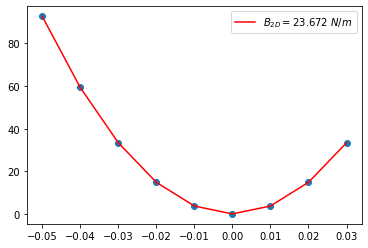

In [10]:
popt, pcov = curve_fit(func, strains, energies) 
perr = np.sqrt(np.diag(pcov))

# get minimal strain
l_opt = (-popt[2] + np.sqrt(popt[2]**2 - 3*popt[1]*popt[3]))/(3*popt[3])

# curvature at minimum (second derivative) in N Å^2/m
B = 2*np.sqrt(popt[2]**2 - 3*popt[1]*popt[3])  

plt.scatter(strains, energies)
plt.plot(strains, func(strains, *popt), '-r', label=r'$B_{2D} = %2.3f\ N/m$' % (B/(4*A0)))
plt.legend()
plt.show()

## Shear Modulus

In [11]:
atoms = bulk('Y', 'hcp', a=30.0827, b=30.0)
atoms.positions[0][2] = 15.0 # vacuum in z-dir
atoms.calc = Mikado

cell_array0 = atoms.cell.array.copy()
cell_array = cell_array0.copy()

A0 = np.cross(cell_array0[0], cell_array0[1])[2]

atoms.get_potential_energy()

1.2858075104528545e-07

In [12]:
strain = 0.01 # strain increment
energies = []

for fac in np.arange(-5,4):
    cell_array[0,0] = (1.0 + fac*strain) * cell_array0[0,0]
    cell_array[1,0] = (1.0 + fac*strain) * cell_array0[1,0]
    cell_array[0,1] = (1.0 - fac*strain) * cell_array0[0,1]
    cell_array[1,1] = (1.0 - fac*strain) * cell_array0[1,1]

    atoms.set_cell(cell_array, scale_atoms=True)
    
    pos0 = atoms.get_positions().flatten()
    ch0 = atoms.get_initial_charges()

    res_tot = minimize(_energy_total, np.concatenate((ch0, pos0)), args=(atoms,), options={'disp': True, 'maxiter': 100, 'gtol': 1e-3})
    energies.append(atoms.get_potential_energy())
    
strains = strain*np.arange(-5,4)
energies = np.array(energies)

Optimization terminated successfully.
         Current function value: 5.345143
         Iterations: 7
         Function evaluations: 117
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 3.409016
         Iterations: 5
         Function evaluations: 90
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 1.915728
         Iterations: 5
         Function evaluations: 90
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.852884
         Iterations: 5
         Function evaluations: 90
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.214181
         Iterations: 5
         Function evaluations: 90
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 90
       

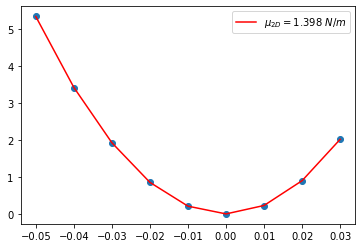

In [13]:
popt, pcov = curve_fit(func, strains, energies) 
perr = np.sqrt(np.diag(pcov))

# get minimal strain
l_opt = (-popt[2] + np.sqrt(popt[2]**2 - 3*popt[1]*popt[3]))/(3*popt[3])

# curvature at minimum (second derivative) in N Å^2/m
mu = 2*np.sqrt(popt[2]**2 - 3*popt[1]*popt[3])  

plt.scatter(strains, energies)
plt.plot(strains, func(strains, *popt), '-r', label=r'$\mu_{2D} = %2.3f\ N/m$' % (mu/(4*A0)))
plt.legend()
plt.show()